## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2018-04-08 14:11:26--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/dCaT8I5w5Eyj87cZk6mTWswHvmQpdjbTZHuIYQ5ZRjvDLvP8QXTREL0TRqqBQDAT/file [following]
--2018-04-08 14:11:27--  https://dl.dropboxusercontent.com/content_link/dCaT8I5w5Eyj87cZk6mTWswHvmQpdjbTZHuIYQ5ZRjvDLvP8QXTREL0TRqqBQDAT/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6, 2620:100:6022:6::a27d:4206
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17887724 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  17,06M  4,77MB/s    in 4,1s    

2018-04-08 14:11:34 

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/igolovanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/igolovanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


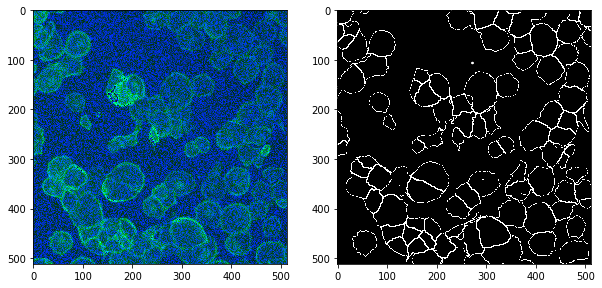

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

#### Dense precition seminar style

In [4]:
from torchvision import transforms

In [264]:
from tqdm import tqdm

In [5]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

import os
from os.path import isfile, join
from tqdm import tqdm

In [7]:
from PIL import Image

In [488]:
class DataLoaderSimple(Dataset):
    def __init__(self, root='.', subset="train", transform=None, fliprob=0.5, img_size=128):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.subset = subset
        self.data_path, self.labels_path = [], []
        self.fliprob = fliprob
        self.img_size = img_size

        def load_images(path):
            images_dir = [join(path, f) for f in os.listdir(path) if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        # load the data regarding the subset
        if self.subset == "train":
            self.data_path = load_images(self.root + "/BBBC018_v1_images-fixed" + "/train")
            self.labels_path = load_images(self.root + "/BBBC018_v1_outlines" + "/train")
        elif self.subset == "val":
            self.data_path = load_images(self.root + "/BBBC018_v1_images-fixed" + "/val")
            self.labels_path = load_images(self.root + "/BBBC018_v1_outlines" + "/val")
        elif self.subset == "test":
            self.data_path = load_images(self.root + "/BBBC018_v1_images-fixed" + "/test")
            self.labels_path = None
        else:
            raise RuntimeError('Invalid subset ' + self.subset + ', it must be one of:'
                                                                 ' \'train\', \'val\' or \'test\'')

    def __getitem__(self, index):
        img = sp.misc.imread(self.data_path[index])
        target = None
        
        img = img / 255
        if len(img.shape) > 2:
            img = img.transpose(2,0,1)
        if self.subset != 'test':
            target = sp.misc.imread(self.labels_path[index])
            target = target / 255
            
            # get random crop
            if self.img_size != 512:
                width_start = np.random.randint(0, 512 - self.img_size)
                height_start = np.random.randint(0, 512 - self.img_size)
            
                img = img[:, width_start:width_start + self.img_size, height_start:height_start+self.img_size]
                target = target[width_start:width_start + self.img_size, height_start:height_start+self.img_size]
            
            for axis in [1,2]:
                if np.random.random() < self.fliprob:
                    img = np.flip(img, axis=axis)
                    target = np.flip(target, axis=axis-1)
                
            return img.copy().astype('float32'), target.copy().astype('float32')
        return img.copy().astype('float32')
        
    def __len__(self):
        return len(self.data_path)

In [489]:
train_dataset = DataLoaderSimple(img_size=256)
for img, target in train_dataset:
    break
img.shape

(3, 256, 256)

In [490]:
target.shape

(256, 256)

In [512]:
def im_show(img_list, n_cols=2):
    
#     if len(img_list) > 19:
#         raise Exception("len(img_list) must be smaller than 20")
    
    n_rows = len(img_list) // n_cols
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4,n_rows*3) )
    
    for ax, img in zip(axes.flat[0:], img_list):
        if len(img.shape) > 2:
            img=img.transpose(1,2,0)
        ax.imshow(img)
    fig.tight_layout()
    plt.show()

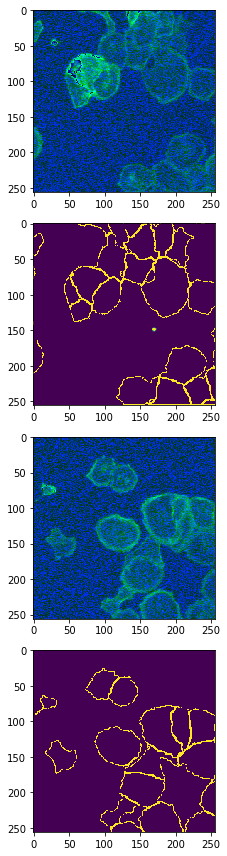

In [493]:
train_dataset = DataLoaderSimple(subset='train',img_size=256)

img_list = []
for i in range(2):
    img, target = train_dataset[i]
    img_list.append(img)
    img_list.append(target)

im_show(img_list, n_cols=1)

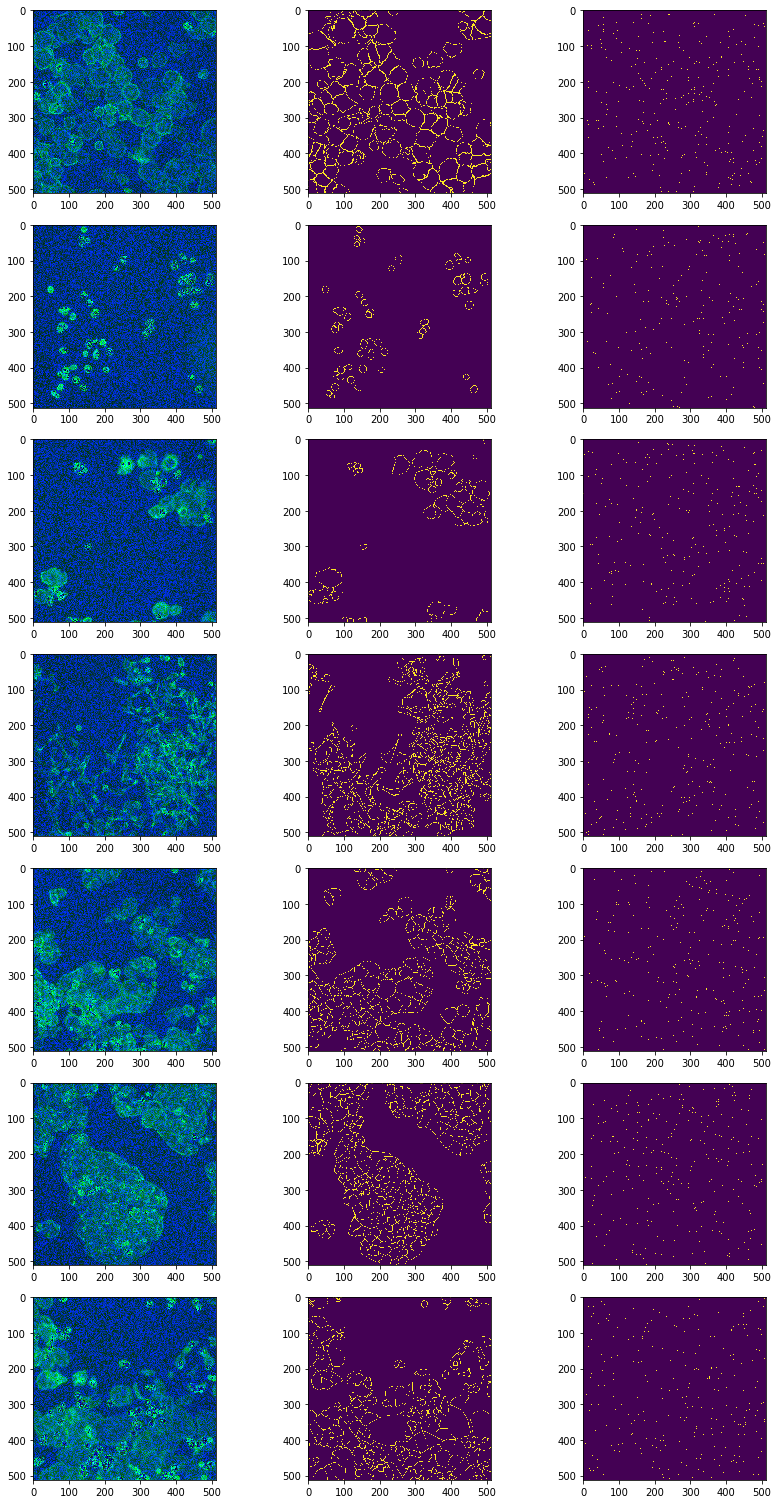

In [516]:
img_list = []
model.eval()
for img,target in val_loader:
#     break
    img_list.append(img.cpu().numpy()[0])
    img_list.append(target.cpu().numpy()[0])
    pred = model(Variable(img.cuda()))
    pred = (pred.data.cpu().numpy()[0][0] > 1.5).copy()
    
    img_list.append(pred)
    
im_show(img_list, n_cols=3)

In [504]:
target.shape

torch.Size([1, 512, 512])

In [505]:
type(pred)

torch.autograd.variable.Variable

In [510]:
pred.

(512, 512)

In [539]:
class conv_block(nn.Module):
    """
    Define the convolutional - batch norm - relu block to avoid re-writing it
    every time
    """

    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,
                              padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


# Define the network
# Then we define the network keeping in mind that down_1 output size should match with
# the scaled output of up_2, while down_2 size should match with the scaled output of the middle 
# convolution of the u-net model.
class small_UNET_256(nn.Module):
    """
    Define UNET model that accepts a 256 input and mostly uses 3x3 kernels
    with stride and padding = 1. It reduces the size of the image to 8x8 pixels
    ** It might not work if the input 'x' is not a square.
    """

    def __init__(self):
        super(small_UNET_256, self).__init__()

        self.down_1 = nn.Sequential(
            conv_block(3, 16),
            conv_block(16, 32, stride=2, padding=1))

        self.down_2 = nn.Sequential(
            conv_block(32, 64),
            conv_block(64, 128))

        self.middle = conv_block(128, 128, kernel_size=1, padding=0)

        self.up_2 = nn.Sequential(
            conv_block(256, 128),
            conv_block(128, 32))

        self.up_1 = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 32))

        self.output = nn.Sequential(
            conv_block(32, 16),
            conv_block(16, 1, kernel_size=1, padding=0))

    def forward(self, x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        out = self.middle(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)

        out = F.upsample(out, scale_factor=2)
        out = F.sigmoid(out)
        
        return self.output(out)

In [540]:
class AverageMeter(object):
    """
    https://github.com/pytorch/examples/blob/master/imagenet/main.py
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(train_loader, model, criterion, num_epochs, print_period=100):
    model.train()
    losses = AverageMeter()
    
    # set a progress bar
    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

            # compute output
            optimizer.zero_grad()
            outputs = model(images)

            # measure loss
            loss = criterion(outputs, labels)
            losses.update(loss.data[0], images.size(0))

            # compute gradient and do SGD step
            loss.backward()
            optimizer.step()
            
        if not(epoch % print_period):
            print('Epoch {}'.format(epoch))
            print('Train loss {}. Train IOU {}'.format(losses.avg, get_iou_score(model, train_loader, num=10)))
            print('Val IOU: {}'.format(get_validation_score(model)))
            
    return losses.avg

In [541]:
def train(train_loader, model, criterion, num_epochs, print_period=100):
    model.train()
    losses = AverageMeter()
    
    # set a progress bar
    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

            # compute output
            optimizer.zero_grad()
            outputs = model(images)

            # measure loss
            loss = criterion(outputs, labels)
            losses.update(loss.data[0], images.size(0))

            # compute gradient and do SGD step
            loss.backward()
            optimizer.step()
            
        if not(epoch % print_period):
            print('Epoch {}'.format(epoch))
            print('Train loss {}. Train IOU {}'.format(losses.avg, get_iou_score(model, train_loader, num=10)))
            print('Val IOU: {}'.format(get_validation_score(model)))
            
    return losses.avg

In [542]:
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights
        
    def forward(self, y_pred, target):
        loss = self.weights[1] * (target * torch.log(y_pred)) + self.weights[0] * ((1 - target) * torch.log(1 - y_pred))
        loss = torch.neg(torch.mean(loss))
        return loss

In [543]:
from IPython.display import clear_output
import time

In [435]:
max_val_score = None
max_val_score_epoch = None
save_path = 'best_model.torch'
train_loss = []
num_epochs = 1000
criterion = BCELoss2d().cuda()
train_loader = train_loader_better
batch_size = 1

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for images, labels in train_loader:
        # Convert torch tensor to Variable
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # compute output
        optimizer.zero_grad()
        outputs = model(images)

        # measure loss
        loss = criterion(outputs, labels)
#         losses.update(loss.data[0], images.size(0))

        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.cpu().numpy()[0])
            
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    
    val_score = get_validation_score(model)
    train_score = get_iou_score(model, train_loader, num=10)
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))
    print("  validation IOU: \t\t\t{:.4f}".format(
        train_score))
    print("  validation IOU: \t\t\t{:.4f}".format(
        val_score))
    
    if max_val_score is None or val_score > max_val_score:
        max_val_score = val_score
        max_val_score_epoch = epoch
        print('this model is best so far, saving it to disk')
        with open(save_path, 'wb') as f:
            torch.save(model.state_dict(), f)
    elif epoch - max_val_score_epoch > 200:
        print('early stopping, loading best model')
        model.load_state_dict(torch.load(save_path))
        break

Epoch 1 of 1000 took 1.196s
  training loss (in-iteration): 	-273.448242
  validation IOU: 			0.0246
  validation IOU: 			0.1122
this model is best so far, saving it to disk


/home/igolovanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Epoch 2 of 1000 took 1.187s
  training loss (in-iteration): 	-266.200256
  validation IOU: 			nan
  validation IOU: 			0.1168
this model is best so far, saving it to disk
Epoch 3 of 1000 took 1.183s
  training loss (in-iteration): 	-289.805634
  validation IOU: 			0.0308
  validation IOU: 			0.1035
Epoch 4 of 1000 took 1.183s
  training loss (in-iteration): 	-226.307907
  validation IOU: 			0.0165
  validation IOU: 			0.1032
Epoch 5 of 1000 took 1.185s
  training loss (in-iteration): 	-290.842712
  validation IOU: 			nan
  validation IOU: 			0.1022
Epoch 6 of 1000 took 1.187s
  training loss (in-iteration): 	-218.324738
  validation IOU: 			0.0138
  validation IOU: 			0.1124
Epoch 7 of 1000 took 1.187s
  training loss (in-iteration): 	-290.526123
  validation IOU: 			0.0473
  validation IOU: 			0.1069
Epoch 8 of 1000 took 1.183s
  training loss (in-iteration): 	-236.087326
  validation IOU: 			0.0488
  validation IOU: 			0.1027
Epoch 9 of 1000 took 1.183s
  training loss (in-iteration)

Epoch 65 of 1000 took 1.181s
  training loss (in-iteration): 	-230.524887
  validation IOU: 			nan
  validation IOU: 			0.0956
Epoch 66 of 1000 took 1.186s
  training loss (in-iteration): 	-254.909943
  validation IOU: 			0.0230
  validation IOU: 			0.1052
Epoch 67 of 1000 took 1.182s
  training loss (in-iteration): 	-237.998306
  validation IOU: 			0.0372
  validation IOU: 			0.1025
Epoch 68 of 1000 took 1.179s
  training loss (in-iteration): 	-240.819717
  validation IOU: 			nan
  validation IOU: 			0.1011
Epoch 69 of 1000 took 1.181s
  training loss (in-iteration): 	-291.390350
  validation IOU: 			0.0501
  validation IOU: 			0.1188
Epoch 70 of 1000 took 1.186s
  training loss (in-iteration): 	-260.385956
  validation IOU: 			0.0411
  validation IOU: 			0.1230
Epoch 71 of 1000 took 1.183s
  training loss (in-iteration): 	-294.422363
  validation IOU: 			nan
  validation IOU: 			0.1128
Epoch 72 of 1000 took 1.184s
  training loss (in-iteration): 	-272.047913
  validation IOU: 			0.05

Epoch 129 of 1000 took 1.186s
  training loss (in-iteration): 	-265.825806
  validation IOU: 			0.0323
  validation IOU: 			0.1185
Epoch 130 of 1000 took 1.182s
  training loss (in-iteration): 	-204.465439
  validation IOU: 			0.0345
  validation IOU: 			0.1159
Epoch 131 of 1000 took 1.181s
  training loss (in-iteration): 	-251.463226
  validation IOU: 			nan
  validation IOU: 			0.1005
Epoch 132 of 1000 took 1.176s
  training loss (in-iteration): 	-292.109894
  validation IOU: 			0.0508
  validation IOU: 			0.1180
Epoch 133 of 1000 took 1.176s
  training loss (in-iteration): 	-301.547363
  validation IOU: 			0.0621
  validation IOU: 			0.0928
Epoch 134 of 1000 took 1.184s
  training loss (in-iteration): 	-318.660309
  validation IOU: 			0.0398
  validation IOU: 			0.0909
Epoch 135 of 1000 took 1.181s
  training loss (in-iteration): 	-271.702820
  validation IOU: 			0.0403
  validation IOU: 			0.1138
Epoch 136 of 1000 took 1.179s
  training loss (in-iteration): 	-276.954193
  validatio

Epoch 192 of 1000 took 1.177s
  training loss (in-iteration): 	-235.543777
  validation IOU: 			nan
  validation IOU: 			0.1004
Epoch 193 of 1000 took 1.180s
  training loss (in-iteration): 	-255.395966
  validation IOU: 			0.0514
  validation IOU: 			0.0977
Epoch 194 of 1000 took 1.181s
  training loss (in-iteration): 	-284.148041
  validation IOU: 			0.0329
  validation IOU: 			0.0984
Epoch 195 of 1000 took 1.177s
  training loss (in-iteration): 	-314.045135
  validation IOU: 			nan
  validation IOU: 			0.0941
Epoch 196 of 1000 took 1.176s
  training loss (in-iteration): 	-280.439728
  validation IOU: 			nan
  validation IOU: 			0.1049
Epoch 197 of 1000 took 1.179s
  training loss (in-iteration): 	-269.470245
  validation IOU: 			0.0504
  validation IOU: 			0.1022
Epoch 198 of 1000 took 1.179s
  training loss (in-iteration): 	-295.906952
  validation IOU: 			nan
  validation IOU: 			0.1227
Epoch 199 of 1000 took 1.179s
  training loss (in-iteration): 	-273.345032
  validation IOU: 		

In [426]:
model = small_UNET_256().cuda()
criterion = BCELoss2d().cuda()
optimizer = torch.optim.SGD(model.parameters(),
                      weight_decay=1e-4,
                      lr=1e-4,
                      momentum=0.9,
                      nesterov=True)
num_epochs = 1000
curr_loss = train(train_loader_better, model, criterion, num_epochs)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0
Train loss -5.872824759018131. Train IOU nan


/home/igolovanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys

  0%|          | 1/1000 [00:01<18:37,  1.12s/it]

Val IOU: 0.02711952971913782



 10%|█         | 100/1000 [01:19<11:52,  1.26it/s]

Epoch 100
Train loss -221.46873438502246. Train IOU 0.05703139302493748



 10%|█         | 101/1000 [01:20<11:54,  1.26it/s]

Val IOU: 0.17513087392107232



 20%|██        | 200/1000 [02:38<10:32,  1.27it/s]

Epoch 200
Train loss -238.8451935146318. Train IOU 0.023516014763666764



 20%|██        | 201/1000 [02:39<10:32,  1.26it/s]

Val IOU: 0.17922003204502493



 30%|███       | 300/1000 [03:56<09:12,  1.27it/s]

Epoch 300
Train loss -246.51984550083353. Train IOU 0.053809923776227356



 30%|███       | 301/1000 [03:57<09:12,  1.26it/s]

Val IOU: 0.17200831693122146



 40%|████      | 400/1000 [05:15<07:53,  1.27it/s]

Epoch 400
Train loss -251.05043746975025. Train IOU 0.05312604910578038



 40%|████      | 401/1000 [05:16<07:53,  1.27it/s]

Val IOU: 0.18161343006939154



 50%|█████     | 500/1000 [06:34<06:34,  1.27it/s]

Epoch 500
Train loss -254.10015121895813. Train IOU 0.032840048989180734



 50%|█████     | 501/1000 [06:35<06:34,  1.27it/s]

Val IOU: 0.12233792909883699



 60%|██████    | 600/1000 [07:53<05:15,  1.27it/s]

Epoch 600
Train loss -255.63310213928307. Train IOU 0.05388207503979836



 60%|██████    | 601/1000 [07:54<05:15,  1.27it/s]

Val IOU: 0.12232417177938039



 70%|███████   | 700/1000 [09:12<03:56,  1.27it/s]

Epoch 700
Train loss -257.47294613887277. Train IOU 0.03516642452059011



 70%|███████   | 701/1000 [09:13<03:55,  1.27it/s]

Val IOU: 0.12884054730540065



 80%|████████  | 800/1000 [10:30<02:37,  1.27it/s]

Epoch 800
Train loss -258.5453749487114. Train IOU 0.030496900496932444



 80%|████████  | 801/1000 [10:32<02:37,  1.27it/s]

Val IOU: 0.136274551883934



 90%|█████████ | 900/1000 [11:49<01:18,  1.27it/s]

Epoch 900
Train loss -259.49827593899954. Train IOU 0.06086133975168055



 90%|█████████ | 901/1000 [11:50<01:18,  1.27it/s]

Val IOU: 0.17144587120783464



100%|██████████| 1000/1000 [13:08<00:00,  1.27it/s]


In [574]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/master/homework03/homework03_part1.ipynb

--2018-04-11 09:32:18--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/master/homework03/homework03_part1.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487763 (476K) [text/plain]
Saving to: ‘homework03_part1.ipynb.1’

homework03_part1.ip 100%[===================>] 476,33K   895KB/s    in 0,5s    

2018-04-11 09:32:20 (895 KB/s) - ‘homework03_part1.ipynb.1’ saved [487763/487763]



In [544]:
def get_iou_score(model, loader, batch_size=1, num=None):
    model.eval()
    score = 0
    cnt = 0
    assert(len(loader) > 0)
    for img,target in loader:
        pred = model(Variable(img.cuda()))
        score += calc_iou(pred.data.cpu().numpy()[0][0] > 0.5, target.cpu().numpy()[0][0])
        cnt += 1
        if num is not None and cnt == num:
            break
        
    model.train()
    return score / len(loader) if num is None else score / num

In [567]:
val_dataset = DataLoaderSimple(subset='val')
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=True, batch_size=len(val_dataset))

In [573]:
model.eval()
for imgs, target in val_loader:
    res = model(Variable(imgs).cuda())
_ = model.train(True)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/torch/lib/THC/generic/THCTensorCopy.c:20

In [545]:
def get_validation_score(model, batch_size=7):
    return get_iou_score(model, val_loader, batch_size=batch_size, num=num)

In [546]:
class BCELoss2d(nn.Module):
    """
    Code taken from:
    https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/37208
    """

    def __init__(self, weight=None, size_average=True):
        super(BCELoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)

    def forward(self, probs, targets):
        probs_flat = probs.view(-1)
        targets_flat = targets.view(-1)
        return self.bce_loss(probs_flat, targets_flat)

In [547]:
batch_size = 1

train_dataset = DataLoaderSimple(img_size=512)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
zero_weight = 0.3

model = small_UNET_256().cuda()
criterion = BCELoss2d().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [548]:
max_val_score = None
max_val_score_epoch = None
save_path = 'best_model.torch'
train_loss = []
num_epochs = 1000

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for images, labels in train_loader:
        # Convert torch tensor to Variable
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # compute output
        optimizer.zero_grad()
        outputs = model(images)

        # measure loss
        loss = criterion(outputs, labels)
#         losses.update(loss.data[0], images.size(0))

        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.cpu().numpy()[0])
            
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    
    val_score = get_validation_score(model)
    train_score = get_iou_score(model, train_loader, num=10)
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))
    print("  validation IOU: \t\t\t{:.4f}".format(
        val_score))
    
    if not np.isnan(val_score) and (max_val_score is None or val_score > max_val_score):
        max_val_score = val_score
        max_val_score_epoch = epoch
        print('this model is best so far, saving it to disk')
        with open(save_path, 'wb') as f:
            torch.save(model.state_dict(), f)
    elif max_val_score_epoch is not None and epoch - max_val_score_epoch > 200:
        print('early stopping, loading best model')
        model.load_state_dict(torch.load(save_path))
        break

RuntimeError: reduce failed to synchronize: device-side assert triggered

In [559]:
val_dataset = DataLoaderSimple(img_size=512, subset="val")
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=7)

In [566]:
Variable(img).shape

torch.Size([7, 3, 512, 512])

In [565]:
for img,target in val_loader:
    preds = model(Variable(img).cuda())

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/torch/lib/THC/generic/THCTensorCopy.c:20

In [361]:
img,target=val_dataset[0]

In [362]:
target

array([[255., 255., 255., ...,   0.,   0.,   0.],
       [255.,   0.,   0., ...,   0.,   0.,   0.],
       [255.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [255.,   0.,   0., ...,   0.,   0., 255.],
       [255.,   0.,   0., ...,   0.,   0., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

In [391]:
get_validation_score(model)

0.37139380120610016
0.37139380120610016
0.37346051764160365
0.4220352743909527
0.4513846719813141
0.46288866743101825
0.5220519426688639


0.07457884895269484

In [398]:
num_epochs = 5
current_epoch = 0
curr_loss = train(train_loader_better, model, criterion, current_epoch, num_epochs)

100%|██████████| 41/41 [00:00<00:00, 51.91it/s]


In [ ]:
train_dataset = DataLoaderSimple()
train_loader_better = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True)

In [294]:
test_dataset = DataLoaderSimple(subset='test', img_size=512)
test_loader_better = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=True)

In [295]:
for img in test_loader_better:
    break

In [296]:
img.shape

torch.Size([1, 3, 512, 512])

In [286]:
_ = model.eval()

In [298]:
res = model(Variable(img.cuda()))

In [347]:
def im_show(img_list, n_cols=2):
    
    if len(img_list) > 19:
        raise Exception("len(img_list) must be smaller than 20")
    
    n_rows = max(len(img_list) // n_cols,1)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4,n_rows*3) )
    
    for ax, img in zip(axes.flat[0:], img_list):
#         if isinstance(img, torch.Variable):
#             print('VARIABLE')
#             img = res.data
            
        if isinstance(img, torch.cuda.FloatTensor):
            print('hey')
            img = img.cpu().numpy()
        print(img.shape)
        if len(img.shape) > 2:
            img=img.transpose(1,2,0)
        if img.shape[-1] == 1:
            img = img[:,:,0]
        ax.imshow(img)
    fig.tight_layout()
    plt.show()

In [348]:
len(res.data)

1

In [352]:
res.data.cpu().numpy() > 0.5

numpy.ndarray

(1, 512, 512)


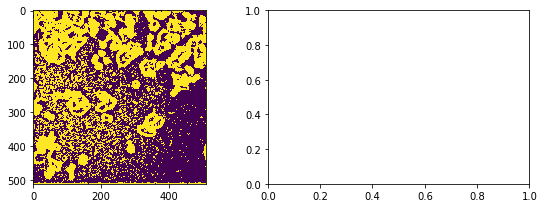

In [353]:
im_show(res.data.cpu().numpy() > 0.5)

In [302]:
res.data.cpu().numpy()[0].shape

(1, 512, 512)

In [80]:
cnt = 0
for img,target in train_dataset:
    print(img)
    to_PIL = transforms.ToPILImage()
    plt.imshow(to_PIL(np.array(img[0])))
    cnt +=1
    if cnt > 4: break


( 0 , 0 ,.,.) = 
    0    0    0  ...     0  255    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
      ...         ⋱        ...      
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0
    0    0    0  ...     0    0    0

( 0 , 1 ,.,.) = 
  165  140  123  ...     0    0    0
  140  123  123  ...    66   66   57
  140  123  132  ...    66   57   57
      ...         ⋱        ...      
   90   90   90  ...    74   74   82
   82   74   90  ...    74   74   74
   90   74   74  ...    74   66   74

( 0 , 2 ,.,.) = 
   57  222  123  ...     0    0    0
   90   82  189  ...    16   33  206
  123  247   74  ...   132  132  140
      ...         ⋱        ...      
  173    8   57  ...    66  148   90
  156  247   99  ...     8  156   99
  148   49  181  ...   239  255   41
[torch.FloatTensor of size 1x3x512x512]



TypeError: Input type float32 is not supported

In [180]:
test_dataset = DataLoaderLocal(subset='test')

In [181]:
def im_show(img_list, n_cols=2):
    if len(img_list) > 19:
        raise Exception("len(img_list) must be smaller than 20")
    
    n_rows = len(img_list) // n_cols
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4,n_rows*3) )
    
    for ax, img in zip(axes.flat[0:], img_list):
        ax.imshow(img)
    fig.tight_layout()
    plt.show()

In [54]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

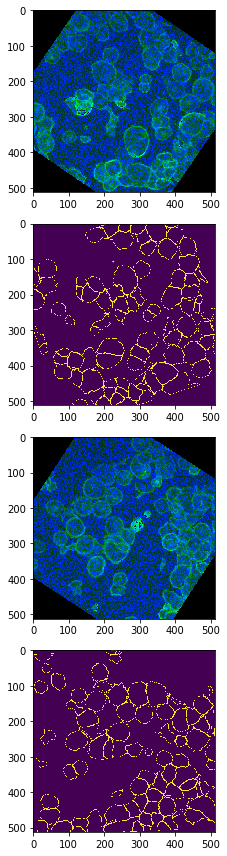

In [186]:
img_list = []
for i in range(2):
    img, label = train_dataset[i]
    img_list.append(img)
    img_list.append(label)

im_show(img_list, n_cols=1)

In [476]:
def read_image(img_name, gt_name=None, path='./BBBC018_v1_images-fixed/train'):
    IMG_HEIGHT = 256
    im = sp.misc.imread(img_name)
    im = sp.misc.imresize(im, IMG_HEIGHT * 1. / im.shape[0])
    if gt_name is not None:
        gt = (sp.misc.imread(gt_name)[:,:,-1]==255).astype(np.uint8)
        gt = sp.misc.imresize(gt, IMG_HEIGHT * 1. / gt.shape[0], 'nearest')
        return im, gt
    return im
def make_blending(img, labels, alpha=0.5):
    colors = np.array([[0,0,0], [0,255,0]], np.uint8)
    return (img*alpha + colors[labels.astype(np.int32)]*(1. - alpha)).astype(np.uint8)

In [150]:
im = sp.misc.imread('./BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
gt = sp.misc.imread('./BBBC018_v1_outlines/train/00735-cells.png')

In [151]:
plt.imshow(make_blending(im,gt))

IndexError: index 255 is out of bounds for axis 0 with size 2

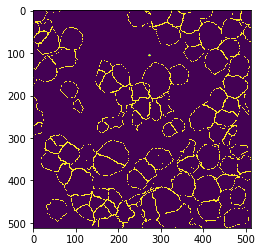

In [13]:
plt.imshow(gt)

In [14]:
def get_valid_patches(img_shape, patch_size, central_points):
    start = central_points - patch_size/2
    end = start + patch_size
    mask = np.logical_and(start >= 0, end < np.array(img_shape))
    mask = np.all(mask, axis=-1)
    return mask

def extract_patches(img, mask, n_pos=64, n_neg=64, patch_size=100):
    res = []
    labels = []
    pos = np.argwhere(mask > 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, pos)
    pos = pos[accepted_patches_mask]
    np.random.shuffle(pos)
    for i in range(n_pos):
        start = pos[i] - patch_size//2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(1)
        
    neg = np.argwhere(mask == 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, neg)
    neg = neg[accepted_patches_mask]
    np.random.shuffle(neg)
    for i in range(n_neg):
        start = neg[i] - patch_size//2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(0)
    return np.array(res), np.array(labels)

In [226]:
patches, labels = extract_patches(im, gt, 32,32, patch_size=128)

In [227]:
patches = patches.transpose(0,3,1,2)

In [228]:
from torch.autograd import Variable

In [229]:
tt = Variable(torch.FloatTensor(patches[:2]))

In [230]:
model = small_UNET_256()

In [231]:
model(tt)

Variable containing:
( 0 , 0 ,.,.) = 
  0.0253  0.0000  0.0000  ...   0.0385  0.0169  0.0161
  0.0000  0.0256  0.0106  ...   0.0798  0.0729  0.0790
  0.0222  0.0558  0.0415  ...   0.0703  0.0584  0.0543
           ...             ⋱             ...          
  0.0000  0.0185  0.0090  ...   0.0000  0.0425  0.0367
  0.0000  0.0414  0.0590  ...   0.0909  0.1052  0.0000
  0.0000  0.0151  0.1322  ...   0.1312  0.0765  0.0000
      ⋮  

( 1 , 0 ,.,.) = 
  0.0000  0.0054  0.0130  ...   0.0153  0.0047  0.0363
  0.0000  0.0283  0.0631  ...   0.0417  0.0242  0.0690
  0.0076  0.0627  0.0744  ...   0.0441  0.0430  0.0737
           ...             ⋱             ...          
  0.0089  0.0000  0.0000  ...   0.0752  0.0574  0.0726
  0.0000  0.0031  0.0864  ...   0.0262  0.0788  0.0876
  0.0377  0.0000  0.0322  ...   0.0686  0.0236  0.0639
[torch.FloatTensor of size 2x1x128x128]

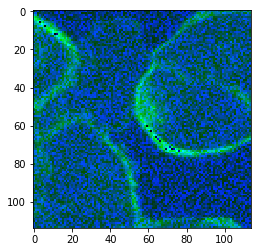

In [189]:
plt.imshow(patches[0])

In [190]:
labels.shape

(64,)